# P3: Wrangling OpenStreetMap Data of Austin, TX

## Part 1. Exploring and Auditing Data

## Data

This project looks at the Austin, TX area, where I live. As delineated in the class, the data was obtained by downloading an already-prepared extract which I found in the link below:

https://mapzen.com/data/metro-extracts/metro/austin_texas/

The 66MB raw OpenStreetMap OSM XML dataset was chosen. After unzipping, the file was about 1.4 GB dataset. Opening this dataset using Sublime took a while.

## Obtaining a sample data set

Since the data were too large to do preliminary investigation, a sample of it was taken using the code provided in the project details instructions. This smaller data were produced by taking only the 10th top level element in the xml tree.

In [1]:
import xml.etree.cElementTree as ET

In [41]:
def get_element(osm_file, tags=('node', 'way', 'relation')):
    """Yield element if it is the right type of tag"""

    context = ET.iterparse(osm_file, events=('start', 'end'))
    _, root = next(context)
    for event, elem in context:
        if event == 'end' and elem.tag in tags:
            yield elem
            root.clear()

In [5]:
OSM_FILE = "austin_texas.osm"
SAMPLE_FILE = "sample.osm"
k = 10

In [7]:
with open(SAMPLE_FILE, 'wb') as output:
    output.write('<?xml version="1.0" encoding="UTF-8"?>\n')
    output.write('<osm>\n  ')

    # Write every kth top level element
    for i, element in enumerate(get_element(OSM_FILE)):
        if i % k == 0:
            output.write(ET.tostring(element, encoding='utf-8'))

    output.write('</osm>')

#### Alternative way of examining smaller data set

In some cases, the complete data were used but instead of iterating through all the elements, the number of iterations was set to a certain number. For example:

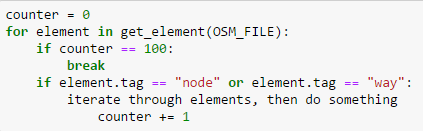

In [1]:
from IPython.display import Image
Image("counter.png")

## Exploration of Dataset

### High Level Tags

To determine the number of high level tags the dataset has, iterative parsing is done. The tags can be counted using a defaultdict.

In [2]:
import xml.etree.cElementTree as ET
from collections import defaultdict
import pprint

In [3]:
def count_tags(filename):
    tag_counts = defaultdict(int)
    for event, elem in ET.iterparse(filename):
        tag_counts[elem.tag] += 1
    return tag_counts

Examination of high level tags in the whole dataset:

In [6]:
tags = count_tags(OSM_FILE)

In [7]:
pprint.pprint(dict(tags))

{'bounds': 1,
 'member': 20197,
 'nd': 6985591,
 'node': 6356394,
 'osm': 1,
 'relation': 2357,
 'tag': 2377504,
 'way': 666390}


### Checking the k values

Checking the k values will give us an idea of how much parameters we're dealing with. The following is the code from the quiz from the case study:

In [8]:
import re

The quiz introduced the following regex expressions, which were contructed based on prior knowledge of the structure/format of the k values. 

The "lower" regex is meant to look for any word that must start with a character from a-z or could contain an underscore.  

The "lower_colon" regex represents values with a colon.

"Problemchars" are those that have any of the characters within the square brackets.

In [9]:
lower = re.compile(r'^([a-z]|_)*$')
lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

In [10]:
def key_type(element, keys):
    if element.tag == 'tag':
        try:
            lower.search(element.attrib['k']).group()
            keys["lower"] += 1
        except AttributeError:
            try:
                lower_colon.search(element.attrib['k']).group()
                keys["lower_colon"] += 1
            except AttributeError:
                try:
                    problemchars.search(element.attrib['k']).group()
                    keys["problemchars"] += 1
                except AttributeError:
                    keys["other"] += 1
    return keys

In [11]:
def process_map_tagtypes(filename):
    keys = {"lower": 0, "lower_colon": 0, "problemchars": 0, "other":0}
    for _, element in ET.iterparse(filename):
        keys = key_type(element, keys)
    return keys

In [12]:
keys = process_map_tagtypes(OSM_FILE)

In [13]:
pprint.pprint(keys)

{'lower': 1297812, 'lower_colon': 1067727, 'other': 11964, 'problemchars': 1}


### Exploring Users

This gives how many users have contributed to the Austin, TX osm file.

In [14]:
def get_user(element):
    return

In [15]:
def process_map_users(filename):
    users = set()
    for _, element in ET.iterparse(filename):
        for key in element.attrib:
            if key == 'uid':
                users.add(element.attrib[key])
    return users

In [16]:
users = process_map_users(OSM_FILE)

In [17]:
len(users)

1155

### Auditing and Improving Street Names 

Auditing the osmfile and using the variable 'mapping', check to see the changes needed to fix the unexpected street types to the appropriate ones in the expected list.

The following regex was used to look for street names.

In [18]:
street_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)

During auditing, street names that have the following elements to the expected list are omitted.

In [19]:
expected = ["Street", "Avenue", "Boulevard", "Drive", "Court", "Place", "Square", "Lane", "Road", 
            "Trail", "Parkway", "Commons", "Cove", "Highway", "Lane"]

audit_street_type function searches for the street name using the regex and adding the name to a set.

In [20]:
def audit_street_type(street_types, street_name):
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group()
        if street_type not in expected:
            street_types[street_type].add(street_name)

The function below determines whether a tag value is a street name.

In [21]:
def is_street_name(elem):
    return (elem.attrib['k'] == "addr:street")

Audits the osm file.

In [22]:
def audit(osmfile):
    osm_file = open(osmfile, "r")
    street_types = defaultdict(set)
    for event, elem in ET.iterparse(osm_file, events=("start",)):
        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_street_name(tag):
                    audit_street_type(street_types, tag.attrib['v'])
    osm_file.close()
    return street_types

Auditing the sample osm file:

In [24]:
st_types = audit(OSM_FILE)

##### Printing out st_types showed streets that need to be fixed. 

In [25]:
st_types

defaultdict(set,
            {'100': {'Avery Ranch Blvd Building A #100',
              'Jollyville Road Suite 100',
              'Old Jollyville Road, Suite 100'},
             '101': {'4207 James Casey st #101'},
             '104': {'11410 Century Oaks Terrace Suite #104',
              'S 1st St, Suite 104'},
             '1100': {'Farm-to-Market Road 1100'},
             '117': {'County Road 117'},
             '12': {'Ranch to Market Road 12'},
             '120': {'Building B Suite 120'},
             '129': {'County Road 129'},
             '1327': {'FM 1327', 'Farm-to-Market Road 1327'},
             '138': {'County Road 138'},
             '1431': {'Farm-to-Market Road 1431', 'Old Farm-to-Market 1431'},
             '150': {'Farm-to-Market Road 150', 'IH-35 South, #150'},
             '1625': {'Farm-to-Market Road 1625'},
             '1626': {'F.M. 1626', 'FM 1626', 'Farm-to-Market Road 1626'},
             '163': {'Bee Cave Road Suite 163'},
             '170': {'County Ro

From looking at the values, some common things to fix are abbreviated street names. An example that needed to be cleaned is the following values for Interstate Highway 35:

"IH35"
"I35"
"I 35"
"I H 35"

Another complicated case was the Farm-to-Market and Ranch-to-Market roads.

"Farm to Market 620"
"Farm to Market Road 620"
"FM 620"
"FM1431"

Cleaning up N (north), I (interstate), H (Highway), E (east) and other single letter abbreviations was needed but this complicated the streets that have values "Avenue N", "Avenue I", "Avenue H", "Avenue E".

Cleaning up St (street) complicated the streets with St for "Saint" (for example, "Rue de Saint Tropez" which was abbreviated "Rue de St Tropez".

All of these were addressed by creating functions shown below. However, some cases were ignored, such as "Highway Interstate 35" which should be "Interstate Highway 35".

To aid in cleaning, the mapping dictionary below was created. The keys are the items to be fixed, and the values are what the keys should be after fixing.

In [26]:
mapping = { "St": "Street",
            "St.": "Street",
            "st": "Street",
            "street": "Street",
            "Street,": "Street",
            "Ave": "Avenue",
            "Ave.": "Avenue",
            "Avene": "Avenue",
            "Blvd": "Boulevard",
            "Blvd.": "Boulevard",
            "Boulevard,": "Boulevard",
            "Blvd,": "Boulevard",
            "Blvd.,": "Boulevard",
            "Dr": "Drive",
            "Dr.": "Drive",
            "Ct": "Court",
            "Ct.": "Court",
            "court": "Court",
            "Cv": "Cove",
            "cove": "Cove",
            "Cc": "Cove",
            "Pl": "Place",
            "Pl.": "Place",
            "lane": "Lane",
            "Ln": "Lane",
            "Rd": "Road", 
            "Rd.": "Road",
            "R": "Road",
            "Trl": "Trail",
            "Tr": "Trail",
            "Pkwy": "Parkway",
            "Hwy": "Highway",
            "HWY": "Highway",
            "Hwy,": "Highway",
            "H": "Highway",
            "I35": "Interstate Highway 35",
            "IH35": "Interstate Highway 35",
            "IH35,": "Interstate Highway 35",
            "IH-35": "Interstate Highway 35",
            "I-35": "Interstate Highway 35",
            "IH": "Interstate Highway",
            "I": "Interstate",
            "35,": "35",
            "main": "Main",
            "N": "North",
            "N.": "North",
            "Ovlk": "Overlook",
            "pass": "Pass",
            "Ps": "Pass",
            "W": "West",
            "W.": "West",
            "E": "East",
            "E.": "East",
            "texas": "Texas",
            "TX": "Texas",
            "FM": "Farm-to-Market Road",
            "F.M.": "Farm-to-Market Road",
            "U.S.": "United States",
            "US": "United States",
            "RM": "Ranch-to-Market Road",
            "RM1431": "Ranch-to-Market Road 1431",
            "RR": "Ranch Road",
            "S": "South",
            "S.": "South",
            "south": "South",
            "Bldg": "Building",
            "Bldg.": "Building",
            "Bld": "Building",
            "Ste": "Suite",
            "Ste,": "Suite",
            "STE": "Suite",
            "Ste.": "Suite",
            "suite": "Suite",
            "C": "Country",
            "church": "Church",
            "brigadoon": "Brigadoon",
            "Drive/Rd": "Drive/Road",
            "Mo-Pac": "MoPac", 
            "Avenue,Ste": "Avenue Suite",
            "suite#L131": "Suite L131"}

##### Appends "Highway" if is it needed:

In [27]:
def append_highway(name):
    newparts = []
    parts = name.split()
    for item in parts:
        if (item == "Interstate" or item == "States") and "Highway" not in parts:
            newparts.append(item)
            newparts.append("Highway")
        else:
            newparts.append(item)
    name = ' '.join(newparts)
    return name

##### Updates the FM and RM roads:

In [28]:
def update_farm_ranch_to_market(name):
    parts = name.split()
    if "Farm-to-Market" in parts or "Ranch-to-Market" in parts:
        if "Road" in parts:
            return name
        else:
            try:
                parts.insert(parts.index("Farm-to-Market")+1, "Road")
                name = " ".join(parts)
            except ValueError:
                parts.insert(parts.index("Ranch-to-Market")+1, "Road")  
                name = " ".join(parts)
    elif "Farm" in parts and "to" in parts and "Market" in parts:
        newname = []
        for i in range(parts.index("Farm")):
            newname.append(parts[parts.index(i)])
        newname.append("Farm-to-Market")
        newname += parts[parts.index("Market")+1:]

        if "Road" in parts:
            name = " ".join(newname)
        else:
            newname.insert(newname.index("Farm-to-Market")+1,"Road")
            name = " ".join(newname)
    
    elif "Ranch" in parts and "to" in parts and "Market" in parts:
        newname = []
        for i in range(parts.index("Ranch")):
            newname.append(parts[parts.index(i)])
        newname.append("Ranch-to-Market")
        newname += parts[parts.index("Market")+1:]

        if "Road" in parts:
            name = " ".join(newname)
        else:
            newname.insert(newname.index("Ranch-to-Market")+1,"Road")
            name = " ".join(newname)
        
    return name

##### Updates the name based on mapping dictionary and also fixes other items, such as St., N, C, I , H:

In [29]:
def update_name(name, mapping):
    parts = name.split()
    newparts = []
    for item in parts:
        if item == "St" and "Rue" in parts:
            newparts.append("Saint")
        elif item == "N" or item == "C" or item == "I" or item == "H": 
            try:
                if newparts[0] == "Avenue":
                    newparts.append(item)
                else:
                    newparts.append(mapping[item])
            except IndexError:
                newparts.append(mapping[item])
        else:
            if item in mapping.keys():
                newparts.append(mapping[item])
            else:
                newparts.append(item)
    name = ' '.join(newparts)
    name = append_highway(name)
    name = update_farm_ranch_to_market(name)
    return name

elif statements make possible the updating of St for Saint instead of Street, and N, C, I, H to be left alone instead of substituting them for "North", "Country", etc. 

The following code shows if the updates can occur using "update_name" function.

In [30]:
for st_type, ways in st_types.iteritems():
    for name in ways:
        for each in name.split():
            if each in mapping.keys():
                better_name = update_name(name, mapping)
                print name, "=>", better_name

Royal Birkdale Ovlk => Royal Birkdale Overlook
N I-35 Suite 298 => North Interstate Highway 35 Suite 298
N I-35 Suite 298 => North Interstate Highway 35 Suite 298
W. Highway 290 => West Highway 290
East Hwy 290 => East Highway 290
C R 290 => Country Road 290
C R 290 => Country Road 290
W Hwy 290 => West Highway 290
W Hwy 290 => West Highway 290
U.S. 290 => United States Highway 290
West US Highway 290 => West United States Highway 290
E Hwy 290 => East Highway 290
E Hwy 290 => East Highway 290
US Highway 290 => United States Highway 290
W Highway 290 => West Highway 290
W HWY 290 => West Highway 290
W HWY 290 => West Highway 290
Helios Way, Bldg 2, Suite 290 => Helios Way, Building 2, Suite 290
US 290 => United States Highway 290
south church street => South Church Street
south church street => South Church Street
south church street => South Church Street
East main street => East Main Street
East main street => East Main Street
South 1st street => South 1st Street
White House street =

##### More things to fix:

- Ranch Road 620 is also Farm-to-Market 620. Which one is correct? I don't know. I'll just leave it as is.
- US highway 290 is also country road 290, etc. Will not fix that one either.

### Other parameters to look at (other values of k under tag)

In [30]:
k = set()
for event, element in ET.iterparse(SAMPLE_FILE):
    if element.tag == "tag" or element.tag == "way":
        for tag in element.iter("tag"):
             k.add(tag.attrib['k'])

In [31]:
len(k)

347

In [32]:
k

{'FIXME',
 'NHS',
 'Texas_Trunk_System',
 'abandoned',
 'access',
 'addr:city',
 'addr:country',
 'addr:housename',
 'addr:housenumber',
 'addr:postcode',
 'addr:state',
 'addr:street',
 'addr:unit',
 'admin_level',
 'aeroway',
 'alt_name',
 'amenity',
 'area',
 'artist_name',
 'artwork_type',
 'atm',
 'attribution',
 'barrier',
 'basin',
 'bench',
 'bicycle',
 'bicycle_parking',
 'boat',
 'border_type',
 'boundary',
 'brand',
 'bridge',
 'bridge:name',
 'building',
 'building:levels',
 'building:min_level',
 'building_1',
 'bus',
 'button_operated',
 'cables',
 'capacity',
 'capacity:disabled',
 'capital',
 'car_wash',
 'cash',
 'cash_in',
 'census:population',
 'circuits',
 'coa:place_id',
 'colour',
 'commercial',
 'construction',
 'contact:phone',
 'covered',
 'craft',
 'created_by',
 'crop',
 'crossing',
 'cuisine',
 'currency:XBT',
 'cutting',
 'cycleway',
 'cycleway:foot',
 'cycleway:left',
 'cycleway:right',
 'delivery',
 'denomination',
 'description',
 'description:en',
 'des

### Auditing and Cleaning Phone Numbers

Following the methods for auditing street names, is_phone function was created:

In [31]:
def is_phone(element):
    return (element.attrib['k'] == "phone" or element.attrib['k'] == "contact:phone")

Regex for phone number:

In [32]:
phone_re = re.compile(r'^\d\d\d\-\d\d\d\-\d\d\d\d$')

Printing out the phone numbers in the sample osm file that do not follow the regex above:

In [36]:
for event, element in ET.iterparse(SAMPLE_FILE):
    if element.tag == "node" or element.tag == "way":
        for tag in element.iter("tag"):
            if is_phone(tag):
                if phone_re.search(tag.attrib['v']) == None:
                    print tag.attrib['v']

(512) 782-5659
(512) 892-6699
+1 512-472-1666
(512) 494-9300
(512)482-8244
+1-512-821-9472
(512) 336-7200
(512) 478-8086
(512) 336-7706
(512) 312-0907
+1 512 357 4143
51224990093
+1 512-275-0852
(512) 524-1311
(512) 246-7645
(512) 528-0027
+1-512-918-0890
+1 512 219 5008
+1 512 634 0070
(512) 528-7700
512 466-3937
(512) 733-6828
(512) 255-3629
5124282500
+1 (512) 469-7000
+1 512 477 4430
(512) 312-1615
+1 512 268 5326
+1 (512) 974-9920
512.386.1295
+1 512 478-8600
+1 512 4771101
+1-512-462-0202
(512) 259-5500
+1-512-690-9340


The following function cleans up the phone numbers:

In [33]:
def update_phone(number):
    phone_re = re.compile(r'^\d\d\d\-\d\d\d\-\d\d\d\d$')
    if phone_re.search(number) == None:
        phno = []
        number = list(number.lstrip("+1"))
        for char in number:
            try:
                if int(char) in [x for x in range(10)]:
                    phno.append(char)
            except ValueError:
                continue
        number = "".join(phno)
        number = number[:3] + "-" + number[3:6] + "-" + number[6:]
                    
    return number

Testing this function:

In [34]:
update_phone("+1 512-472-1666")

'512-472-1666'

In [35]:
for event, element in ET.iterparse(SAMPLE_FILE):
    for tag in element.iter("tag"):
            if is_phone(tag):
                print tag.attrib['v'], "=>", update_phone(tag.attrib['v'])

+1 512 322-9168 => 512-322-9168
+1 512 322-9168 => 512-322-9168
(512) 282-0182 => 512-282-0182
(512) 282-0182 => 512-282-0182
512-442-0655 => 512-442-0655
512-442-0655 => 512-442-0655
512-386-3300 => 512-386-3300
512-386-3300 => 512-386-3300
512-447-8288 => 512-447-8288
512-447-8288 => 512-447-8288
512-442-8476 => 512-442-8476
512-442-8476 => 512-442-8476
512-478-1933 => 512-478-1933
512-478-1933 => 512-478-1933
512-447-1447 => 512-447-1447
512-447-1447 => 512-447-1447
512-442-6719 => 512-442-6719
512-442-6719 => 512-442-6719
512-892-6038 => 512-892-6038
512-892-6038 => 512-892-6038
512-476-6941 => 512-476-6941
512-476-6941 => 512-476-6941
512-478-5684 => 512-478-5684
512-478-5684 => 512-478-5684
512-444-0762 => 512-444-0762
512-444-0762 => 512-444-0762
512-345-3771 => 512-345-3771
512-345-3771 => 512-345-3771
512-444-1449 => 512-444-1449
512-444-1449 => 512-444-1449
512-345-8314 => 512-345-8314
512-345-8314 => 512-345-8314
512-385-7265 => 512-385-7265
512-385-7265 => 512-385-7265
512-

The test above revealed that some phone numbers are not properly cleaned, such as if there are two phone numbers provided. This might be cleaned by creating another field for the other phone number. This will not be done here. Instead the update_phone function will be modified:

In [36]:
def update_phone(number):
    phone_re = re.compile(r'^\d\d\d\-\d\d\d\-\d\d\d\d$')
    if phone_re.search(number) == None:
        phno = []
        number = list(number.lstrip("+1"))
        for char in number:
            try:
                if int(char) in [x for x in range(10)]:
                    if len(phno) == 10:
                        continue
                    phno.append(char)
            except ValueError:
                continue
        number = "".join(phno)
        number = number[:3] + "-" + number[3:6] + "-" + number[6:]
                    
    return number

Testing the function below:

In [37]:
update_phone("+1-512-666-5286;+1-855-444-8301")

'512-666-5286'

#### Postal Code

Exploration of k values from parsing the whole osm file revealed that postcode is referred to as addr:postcode or postal_code. Hence, the following function for returning postcode values:

In [38]:
def is_postcode(element):
    return (element.attrib['k'] == "addr:postcode" or element.attrib['k'] == "postal_code")

Regex for postcode:

In [39]:
postcode_re = re.compile(r'^7\d\d\d\d$')

To explore the postcode, here we use a counter and the get_element function used in making the sample file on the whole file instead of the sample osm file:

In [42]:
counter = 0
for element in get_element(OSM_FILE):
    if counter == 25:
        break
    if element.tag == "node" or element.tag == "way":
        for tag in element.iter("tag"):
            if is_postcode(tag):
                if postcode_re.search(tag.attrib['v']) == None:
                    print tag.attrib['v']
                    counter += 1

78704-5639
78753-4150
78728-1275
78758-7008
78758-7013
14150
78704-7205
76574-4649
TX 78613
TX 78728
78640-4520
TX 78724
78640-6137
TX 78758
TX 78745
TX 78735
78728-1275
78759-3504
78724-1199
78724-1199
78724-1199
78724-1199
78724-1199
Texas
78640-6137


Based on these values, the function below us created to clean the data:

In [66]:
def update_postcode(postcode):
    postcode_re = re.compile(r'^7\d\d\d\d$')
    if postcode_re.search(postcode) == None:
        zipcounty_re = re.compile(r'^7\d\d\d\d\-\d\d\d\d$')
        if zipcounty_re.search(postcode) != None:
            postcode = postcode.split('-')[0]
            #countycode = postcode.split('-')[1]
        else:
            for item in postcode.split():
                if postcode_re.search(item) != None:
                    postcode = item
                    continue
                else:
                    postcode = 'None'
    return postcode

Testing the function below on "Texas":

In [67]:
update_postcode('Texas')

'None'

In [68]:
update_postcode('TX 78724')

'78724'

Initially, when the postcode is not correct, it was set to the None value, which caused the final processing create an error. Only when the value was set to a string did make the final processing function work.

#### Note on running the codes:

I initially was using an old MacBook Pro 2.66 MHz Intel Core I7 with 8GB ram  to run my codes, but it was a pain running the final processing code. So I transferred to another computer available to me, a Dell Desktop PC Intel Core i7 with 2.67 GHz with 8GB ram, which I found to process my data faster. 

In [47]:
from time import time

In [69]:
t0 = time()
counter = 0
for element in get_element(OSM_FILE):
    if counter == 25:
        break
    if element.tag == "node" or element.tag == "way":
        for tag in element.iter("tag"):
            if is_postcode(tag):
                if postcode_re.search(tag.attrib['v']) == None:
                    print tag.attrib['v'], "=>", update_postcode(tag.attrib['v'])
                    counter += 1
print "Processing time: ", round(time() - t0, 3), "s"

78704-5639 => 78704
78753-4150 => 78753
78728-1275 => 78728
78758-7008 => 78758
78758-7013 => 78758
14150 => None
78704-7205 => 78704
76574-4649 => 76574
TX 78613 => 78613
TX 78728 => 78728
78640-4520 => 78640
TX 78724 => 78724
78640-6137 => 78640
TX 78758 => 78758
TX 78745 => 78745
TX 78735 => 78735
78728-1275 => 78728
78759-3504 => 78759
78724-1199 => 78724
78724-1199 => 78724
78724-1199 => 78724
78724-1199 => 78724
78724-1199 => 78724
Texas => None
78640-6137 => 78640
Processing time:  63.616 s


Running this code on the bigger file allowed me to see this postcode, which didn't seem to get updated:

In [50]:
update_postcode('78626‎')

'None'

### Auditing the city data

In [70]:
def is_city(element):
    return element.attrib['k'] == "addr:city"

Here, it is probably best to create a list of expected cities:

In [71]:
expectedcities = ['Austin', 'Buda', 'Round Rock', 'Leander', 'Lago Vista', 'Kyle', 'Pflugerville',
                  'Cedar Park', 'Manchaca', 'Del Valle', 'Dripping Springs', 'Bee Cave', 'Bastrop', 
                  'Cedar Creek', 'Creedmoor', 'Driftwood', 'Elgin', 'Georgetown', 'Hutto', 
                  'Jonestown', 'Lakeway', 'Lost Pines', 'Manor', 'Maxwell', 'San Marcos', 
                  'Smithville', 'Spicewood', 'Sunset Valley', 'Taylor', 'Webberville',
                  'West Lake Hills', 'Wimberley']

In [72]:
t0 = time()
cities = set()
for element in get_element(OSM_FILE):
    if element.tag == "node" or element.tag == "way":
        for tag in element.iter("tag"):
            if is_city(tag):
                if tag.attrib['v'] not in expectedcities:
                    cities.add(tag.attrib['v'])
print "procesing_time: ", round(time() - t0, 3), "s"

procesing_time:  106.215 s


In [73]:
cities

{'Austin, TX',
 'Austin, Tx',
 'Austin;TX;USA',
 'Barton Creek',
 'Bastrop, TX',
 'Cedar Park, TX',
 'Dripping Springs TX',
 'Dripping Springs, Tx',
 'Elgin, TX',
 'Georgetown, TX',
 'Kyle, TX',
 'Leander, TX',
 'Manchaca,',
 'N Austin',
 'Pflugerville, TX',
 'Round Rock, TX',
 'San Gabriel Village Boulevard',
 'Spicewood, TX',
 'Ste 128, Austin',
 'Taylor, TX',
 'Westlake Hills, TX',
 'austin',
 'kyle'}

From above, the errant values have ", TX" or the first letter is not capitalized. A few are not cities at all, but probably a street address.

As in update_name function for street names, a dictionary for mapping is good to use:

In [74]:
mapping_city = {
    "austin": "Austin",
    "Austin, TX": "Austin",
    "Cedar Park, TX": "Cedar Park",
    "Round Rock, TX": "Round Rock",
    "Dripping Springs, TX": "Dripping Springs",
    "Westlake Hills, TX": "West Lake Hills",
    "kyle": "Kyle",
    "Austin;TX;USA": "Austin",
    "Barton Creek": "Austin",
    "Austin, Tx": "Austin",
    "Taylor, TX": "Taylor",
    "San Gabriel Village Boulevard": "Georgetown",
    "Spicewood, TX": "Spicewood",
    "Ste 128, Austin": "Austin",
    "Pflugerville, TX": "Pflugerville",
    "Manchaca,": "Manchacha",
    "Elgin, TX": "Elgin",
    "Kyle, TX": "Kyle",
    "Dripping Springs, Tx": "Dripping Springs",
    "Bastrop, TX": "Bastrop",
    "Georgetown, TX": "Georgetown",
    "Dripping Springs TX": "Dripping Springs",
    "Leander, TX": "Leander"
}

In [75]:
def update_city(city):
    if city not in expectedcities:
        if city in mapping_city.keys():
            city = mapping_city[city]
        else:
            for name in city.split():
                if name in expectedcities:
                    city = name
    else:
        city = "None"
    return city

Testing the function:

In [76]:
for element in get_element(OSM_FILE):
    if element.tag == "node" or element.tag == "way":
        for tag in element.iter("tag"):
            if is_city(tag):
                if tag.attrib['v'] not in expectedcities:
                    print tag.attrib['v'], "=>", update_city(tag.attrib['v'])

Austin, TX => Austin
Austin, TX => Austin
Austin, TX => Austin
Austin, TX => Austin
Pflugerville, TX => Pflugerville
Elgin, TX => Elgin
Austin, TX => Austin
Spicewood, TX => Spicewood
Austin, TX => Austin
Austin, TX => Austin
Austin, TX => Austin
Austin, TX => Austin
Austin, TX => Austin
Pflugerville, TX => Pflugerville
Austin, TX => Austin
Austin, TX => Austin
Austin, TX => Austin
Austin, TX => Austin
Austin, TX => Austin
Cedar Park, TX => Cedar Park
Austin, TX => Austin
Austin, TX => Austin
Austin, TX => Austin
Austin, TX => Austin
Austin, TX => Austin
Westlake Hills, TX => West Lake Hills
Bastrop, TX => Bastrop
Dripping Springs, Tx => Dripping Springs
Georgetown, TX => Georgetown
Austin, TX => Austin
Round Rock, TX => Round Rock
Taylor, TX => Taylor
Austin, TX => Austin
Cedar Park, TX => Cedar Park
Barton Creek => Austin
austin => Austin
Austin, TX => Austin
Austin, TX => Austin
Austin, TX => Austin
Kyle, TX => Kyle
Austin, TX => Austin
Austin, TX => Austin
austin => Austin
Austin, 